# **銀行解約データセットを使用した二項分類**
Binary Classification with a Bank Churn Dataset(https://www.kaggle.com/competitions/playground-series-s4e1/code?competitionId=65711&sortBy=voteCount)

# 参考資料
**書籍**


**Kaggle**
- [[PlayGround S4E1] 📊 EDA + 🤖 Modeling [XGBoost]](https://www.kaggle.com/code/akhiljethwa/playground-s4e1-eda-modeling-xgboost)
- [Bank Churn CatBoost - 0.89626](https://www.kaggle.com/code/aspillai/bank-churn-catboost-0-89626)


**自分で作成したファイル**
- Home_Credit_Default_Risk
- 肝硬変の転帰の多クラス予測
- 馬の健康への影響を予測する
- ルワンダにおける CO2 排出量を予測する

**その他**


## ライブラリ・データセットのインポート

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

## 実行時間を調べるために使う

In [3]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [4]:
FILE_PATH = '/kaggle/input/playground-series-s4e1/'
OUTPUT_DIR = '/kaggle/working/'

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['Exited']
target_col = 'Exited'

target_name = str(train.iloc[:, [-1]].columns.tolist()) # カラム数-2の値が目的変数

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns

## 前処理

### 欠損値の補完

In [5]:
def missing_values(df):

    return df

### 外れ値の修正

In [6]:
def outlier(df):

    return df

### スケーリング（標準化）

- MinMaxScaler(正規化)

In [7]:
def scaling_MinMaxScaler(df, scale_cols):
    df_scale = df[scale_cols]
    sc = MinMaxScaler()
    df[scale_cols] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

## 特徴量エンジニアリング

### 特徴量の作成

In [8]:
def create_new_features(df):
    # Salary to Balance Ratio
    df['SalaryToBalanceRatio'] = df['EstimatedSalary'] / (df['Balance'] + 1)  # Adding 1 to avoid division by zero

    # Credit Card and Active Member Interaction
    df['CreditCard_ActiveMember'] = df['HasCrCard'] * df['IsActiveMember']


    # ABP Interaction
    df['ABPInteraction'] = df['Age'] * df['Balance'] / df['NumOfProducts']

    df['Geo_Gender'] = df['Geography'] + '_' + df['Gender']
    
    df['TotalProductUsage'] = df['Tenure'] * df['NumOfProducts']
            
    df['AgeAdjustedProductUsage'] = df['NumOfProducts']/((df['Tenure']+1) * df['Age'])
    
    df['Customer_Status'] = df['Tenure'].apply(lambda x: 'New' if x < 2 else 'Long-term')
    
    # 高齢者を1とするカラムを作成する
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    
    return df

#### ビンニング

In [9]:
def binning(df):
    # Age Group
    age_bins = [0, 18, 30, 40, 50, 60, 100]
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=False, right=False)
    
    # Balance Category
    balance_bins = [-np.inf, 0, 10000, 50000, 100000, np.inf]
    df['BalanceCategory'] = pd.cut(df['Balance'], bins=balance_bins, labels=False, right=False)
    
    # Credit Score Category
    credit_bins = [0, 500, 600, 700, 800, 900]
    df['CreditScoreCategory'] = pd.cut(df['CreditScore'], bins=credit_bins, labels=False, right=False)
    
    tenure_bins = [0, 2, 5, 10, np.inf]
    df['TenureGroup'] = pd.cut(df['Tenure'], bins=tenure_bins, labels=False, right=False)
    
    return df

### カテゴリ変数のエンコーディング

* One-HotEncoding

In [10]:
def one_hot_encoding(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)

    return df

- LabelEncoding

In [11]:
def label_encoder(df):
    categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

- pd.get_dummies

In [12]:
def get_dummies(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)
    
    return df

### 特徴量の選択

#### 特徴量の重要度評価

In [13]:
def feature_importance_evaluation(df):
    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
    X = X.drop([target_col], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    

    # 特徴量の重要度評価
    clf = LGBMClassifier(
        random_state=42,
    )

    clf.fit(X, y)
    importance = clf.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

#### 特徴量の削除

In [14]:
def drop_columns(df):
    drop_list = [
        'CustomerId', 'Surname',
        'AgeAdjustedProductUsage',
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

### データセットの更新

In [15]:
# 前処理
df = missing_values(df)
df = outlier(df)

scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
# df = scaling_MinMaxScaler(df, scale_cols) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = binning(df)
df = missing_values(df)
df = drop_columns(df)

ohe_cols = [] # One-Hot Encodingしたい水準数の少ないカラムを指定する
dummies_cols = ['Geography','Gender','IsActiveMember','HasCrCard','NumOfProducts', 'Geo_Gender', 'Customer_Status'] # pd.get_dummiesしたい水準数の少ないカラムを指定する
df = one_hot_encoding(df, ohe_cols)
df = get_dummies(df, dummies_cols)
# df = label_encoder(df)

In [16]:
train = df[:165034]
test = df[165034:]

train_x = train.drop(columns=[target_col])
train_y = target
test_x = test.drop(columns=[target_col])

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.head()

,index,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,SalaryToBalanceRatio,CreditCard_ActiveMember,ABPInteraction,TotalProductUsage,IsSenior,AgeGroup,BalanceCategory,CreditScoreCategory,TenureGroup,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,Geo_Gender_France_Female,Geo_Gender_France_Male,Geo_Gender_Germany_Female,Geo_Gender_Germany_Male,Geo_Gender_Spain_Female,Geo_Gender_Spain_Male,Customer_Status_Long-term,Customer_Status_New
0,0,668,33.00000,3,0.00000,181449.97000,0.00000,181449.97000,0.00000,0.00000,6,0,2,1,2,1,True,False,False,False,True,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False
1,1,627,33.00000,1,0.00000,49503.50000,0.00000,49503.50000,1.00000,0.00000,2,0,2,1,2,0,True,False,False,False,True,False,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True
2,2,678,40.00000,10,0.00000,184866.69000,0.00000,184866.69000,0.00000,0.00000,20,0,3,1,2,3,True,False,False,False,True,True,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False
3,3,581,34.00000,2,148882.54000,84560.88000,0.00000,0.56797,1.00000,5062006.36000,2,0,2,4,1,1,True,False,False,False,True,False,True,False,True,True,False,False,False,False,True,False,False,False,False,True,False
4,4,716,33.00000,5,0.00000,15068.83000,0.00000,15068.83000,1.00000,0.00000,10,0,2,1,3,2,False,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,False,False,True,True,False


In [17]:
# 特徴量の重要度評価
train_importance = train
feature_importance = feature_importance_evaluation(train_importance)
feature_importance

,importance
IsSenior,0
AgeGroup,0
CreditScoreCategory,0
TenureGroup,0
BalanceCategory,11
CreditCard_ActiveMember,94
index,200
ABPInteraction,219
EstimatedSalary,237
SalaryToBalanceRatio,246


<Axes: >

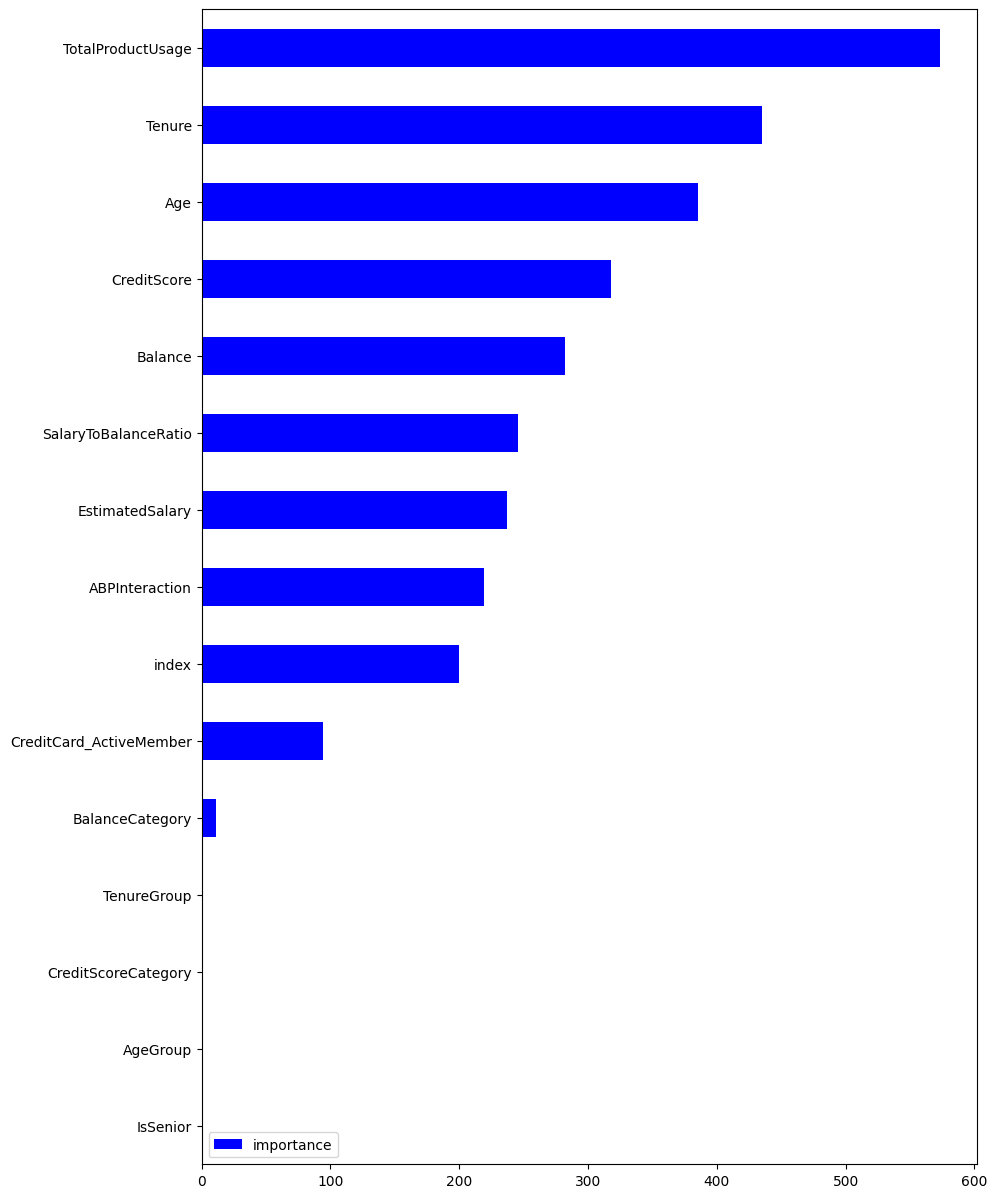

In [18]:
feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [19]:
df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

In [20]:
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:165034].reset_index(drop=True)
    test = data[165034:].reset_index(drop=True).drop(target_col, axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop([target_col], axis=1) # 目的変数を指定する
    y = train[target_col].values # 目的変数を指定する

    return data,test,train,X,y

In [21]:
filename = 'data.csv'
data,test,train,X,y = file_to_xy(OUTPUT_DIR + filename)

読み込み完了 /kaggle/working/data.csv
